**Requirements:**
* Trained models
* GROVER: 
     * fine-tuned:      `'a2e83773f445adf813284155efbede9e'` 
     * non-pretrained: `'5cacac24918054861104eacff97fcf5c'`

Here everything is in setting 2 (extended gene set, 977 L1000 + 1023 HVGs) 

**Outputs:**
* **Figure 4 for GROVER** 
* Figure 5 with DEGs for GROVER
* Supplement Figure 13 for GROVER
___
# Imports

In [1]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred, compute_pred_ctrl
from chemCPA.data import load_dataset_splits


from chemCPA.paths import FIGURE_DIR

[15:38:00] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.1.so: cannot open shared object file: No such file or directory
Using backend: pytorch


In [2]:
BLACK = False 

if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.style.use("seaborn-talk")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

In [3]:
%load_ext autoreload
%autoreload 2

# Load model configs and dataset
* Define `seml_collection` and `model_hash` to load data and model

In [4]:
seml_collection = "finetuning_num_genes"

# GROVER, batch 10  
# split_ood_finetuning, append_ae_layer: true
model_hash_pretrained = "a2e83773f445adf813284155efbede9e" # Fine-tuned
model_hash_scratch = "5cacac24918054861104eacff97fcf5c" # Non-pretrained

## Load config and SMILES

In [5]:
config = load_config(seml_collection, model_hash_pretrained)
dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)

Get list of drugs that are ood in `ood_drugs`

In [7]:
ood_drugs = dataset.obs.condition[dataset.obs[config["dataset"]["data_params"]["split_key"]].isin(['ood'])].unique().to_list()

## Load dataset splits

In [8]:
config['dataset']['data_params']

{'covariate_keys': 'cell_type',
 'dataset_path': '/storage/groups/ml01/projects/2021_chemicalCPA_leon.hetzel/datasets/sciplex_complete_middle_subset.h5ad',
 'degs_key': 'all_DEGs',
 'dose_key': 'dose',
 'pert_category': 'cov_drug_dose_name',
 'perturbation_key': 'condition',
 'smiles_key': 'SMILES',
 'split_key': 'split_ood_finetuning',
 'use_drugs_idx': True}

In [9]:
data_params = config['dataset']['data_params']
datasets = load_dataset_splits(**data_params, return_dataset=False)

____
# Run models
## Baseline model

In [10]:
dosages = [1e1,1e2,1e3,1e4]
cell_lines = ["A549", "K562", "MCF7"]
use_DEGs = True

In [11]:
drug_r2_baseline_degs, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=True,
                                        verbose=False,
                                       )

drug_r2_baseline_all, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=False,
                                        verbose=False,
                                       )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

## Pretrained model

In [12]:
ood_drugs

['Hesperadin',
 'CUDC-101',
 'Raltitrexed',
 'Trametinib',
 'Dacinostat',
 'CUDC-907',
 'Pirarubicin',
 'Tanespimycin',
 'Givinostat']

In [13]:
config = load_config(seml_collection, model_hash_pretrained)
config['dataset']['n_vars'] = dataset.n_vars
model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
drug_r2_pretrained_degs, _ = compute_pred(model_pretrained, 
                                     datasets['ood'], 
                                     genes_control=datasets['test_control'].genes, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=True,
                                     verbose=False,
                                    )

drug_r2_pretrained_all, _ = compute_pred(model_pretrained, 
                                     datasets['ood'], 
                                     genes_control=datasets['test_control'].genes, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=False,
                                     verbose=False,
                                    )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

## Non-pretrained model

In [15]:
config = load_config(seml_collection, model_hash_scratch)
config['dataset']['n_vars'] = dataset.n_vars
model_scratch, embedding_scratch = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
drug_r2_scratch_degs, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=True,
                                  verbose=False,
                                 ) # non-pretrained

drug_r2_scratch_all, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=False,
                                  verbose=False,
                                 ) # non-pretrained

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

# Combine results and create dataframe

In [17]:
def create_df(drug_r2_baseline, drug_r2_pretrained, drug_r2_scratch):
    df_baseline = pd.DataFrame.from_dict(drug_r2_baseline, orient='index', columns=['r2_de'])
    df_baseline['type'] = 'baseline'
    df_pretrained = pd.DataFrame.from_dict(drug_r2_pretrained, orient='index', columns=['r2_de'])
    df_pretrained['type'] = 'pretrained'
    df_scratch = pd.DataFrame.from_dict(drug_r2_scratch, orient='index', columns=['r2_de'])
    df_scratch['type'] = 'non-pretrained'

    df = pd.concat([df_pretrained, df_scratch, df_baseline])

    df['r2_de'] = df['r2_de'].apply(lambda x: max(x,0))
    df['cell_line'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[0]).values
    df['drug'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[1]).values
    df['dose'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[2]).values
    df['dose'] = df['dose'].astype(float)

    df['combination'] = df.index.values
    assert (df[df.type=='pretrained'].combination == df[df.type=='non-pretrained'].combination).all()

    delta = (df[df.type=='pretrained'].r2_de - df[df.type=='non-pretrained'].r2_de).values 
    df['delta'] = list(delta) + list(-delta) + [0]*len(delta)

    df = df.reset_index()
    return df

In [18]:
df_degs = create_df(drug_r2_baseline_degs, drug_r2_pretrained_degs, drug_r2_scratch_degs)
df_all = create_df(drug_r2_baseline_all, drug_r2_pretrained_all, drug_r2_scratch_all)

# Plot Figure 4 for GROVER

In [19]:
SAVEFIG = False

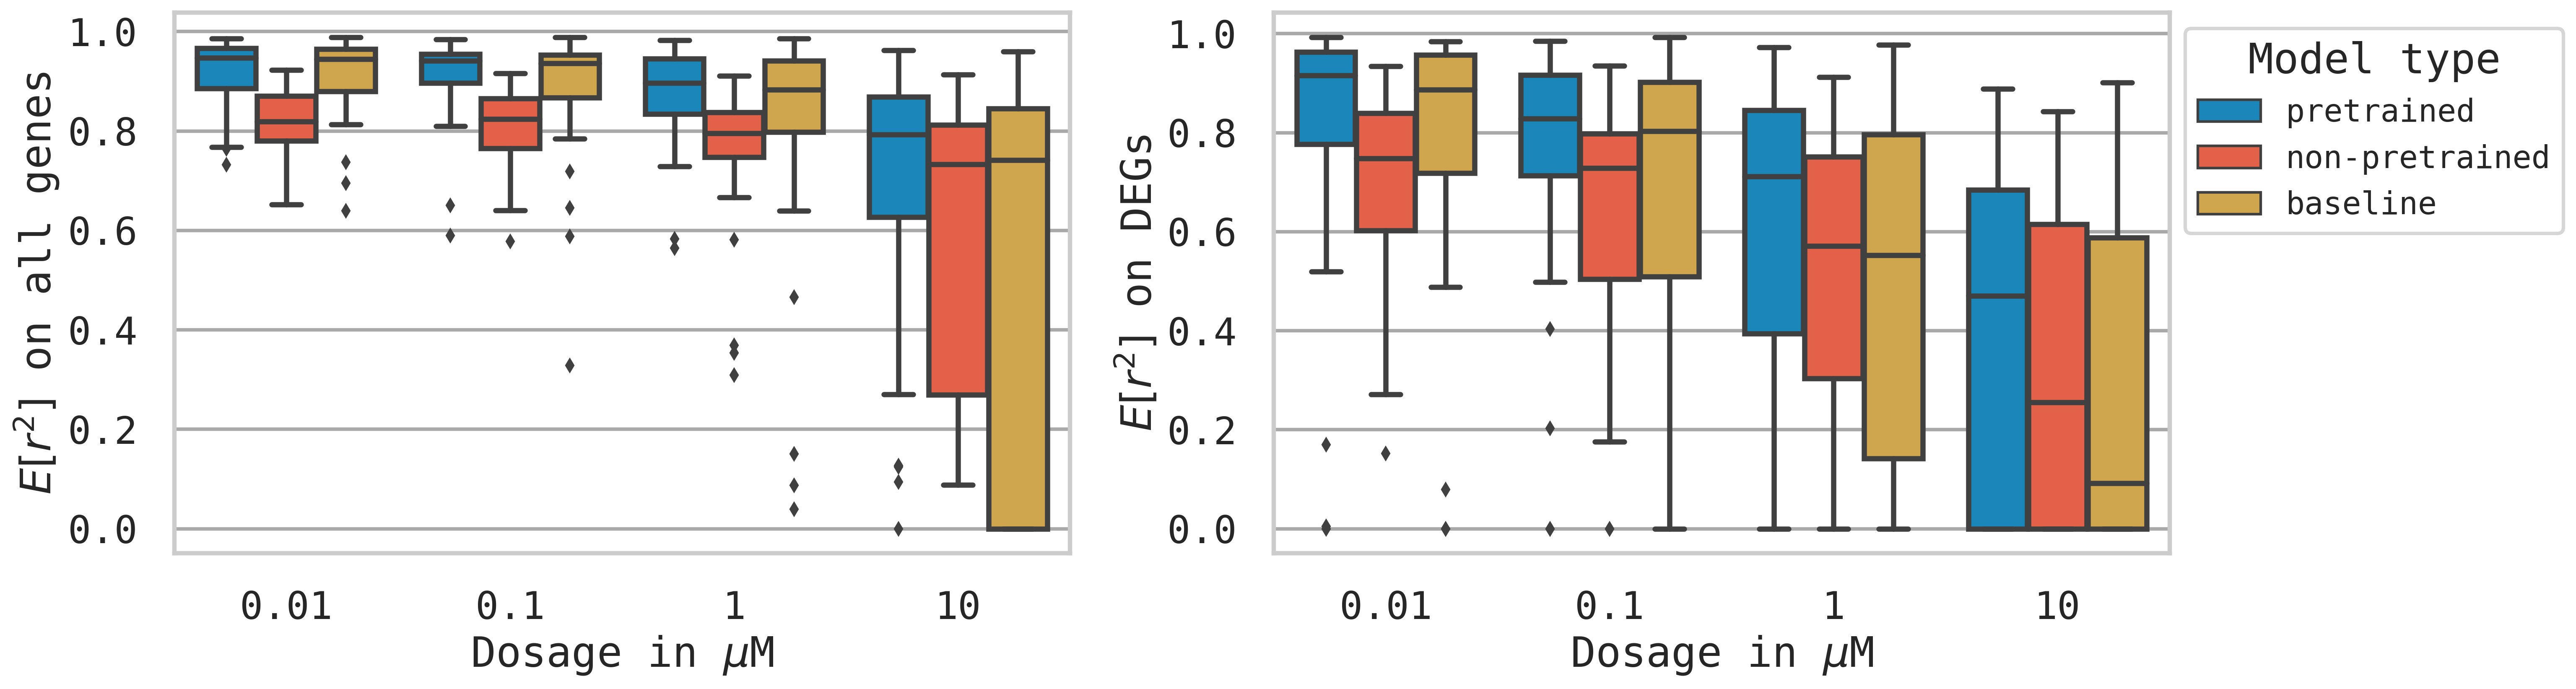

In [20]:
fig, ax = plt.subplots(1,2,figsize=(21, 6))

PROPS = {
    'boxprops':{'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}, 
    'flierprops': {'markerfacecolor': 'lightgrey', "markeredgecolor": "lightgrey"}
}

if BLACK: 
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
else:
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0])
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1])

for j,axis in enumerate(ax):
    x_labels = axis.get_xticklabels()
    dose_labels = ['0.01', "0.1", '1', '10']
    [label.set_text(dose_labels[i]) for i,label in enumerate(x_labels)]
    axis.set_xticklabels(x_labels)
    axis.set_ylabel("$E[r^2]$ on DEGs") if j==1 else None
    axis.set_ylabel("$E[r^2]$ on all genes") if j==0 else None
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.grid('.', color='darkgrey', axis='y')

ax[0].legend().remove()
ax[1].legend(title='Model type', fontsize=18, title_fontsize=24, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'GROVER_extended_gene_set_black.eps', format='eps') # BLACK:
    else:
        plt.savefig(FIGURE_DIR/'GROVER_extended_gene_set.eps', format='eps') # WHITE


________

# Additional: Supplement Figure 13 and Figure 5
**Parameters**
* DEGs
* Extended gene set

In [21]:
ood_drugs

['Hesperadin',
 'CUDC-101',
 'Raltitrexed',
 'Trametinib',
 'Dacinostat',
 'CUDC-907',
 'Pirarubicin',
 'Tanespimycin',
 'Givinostat']

## Supplement Figure 13 for GROVER

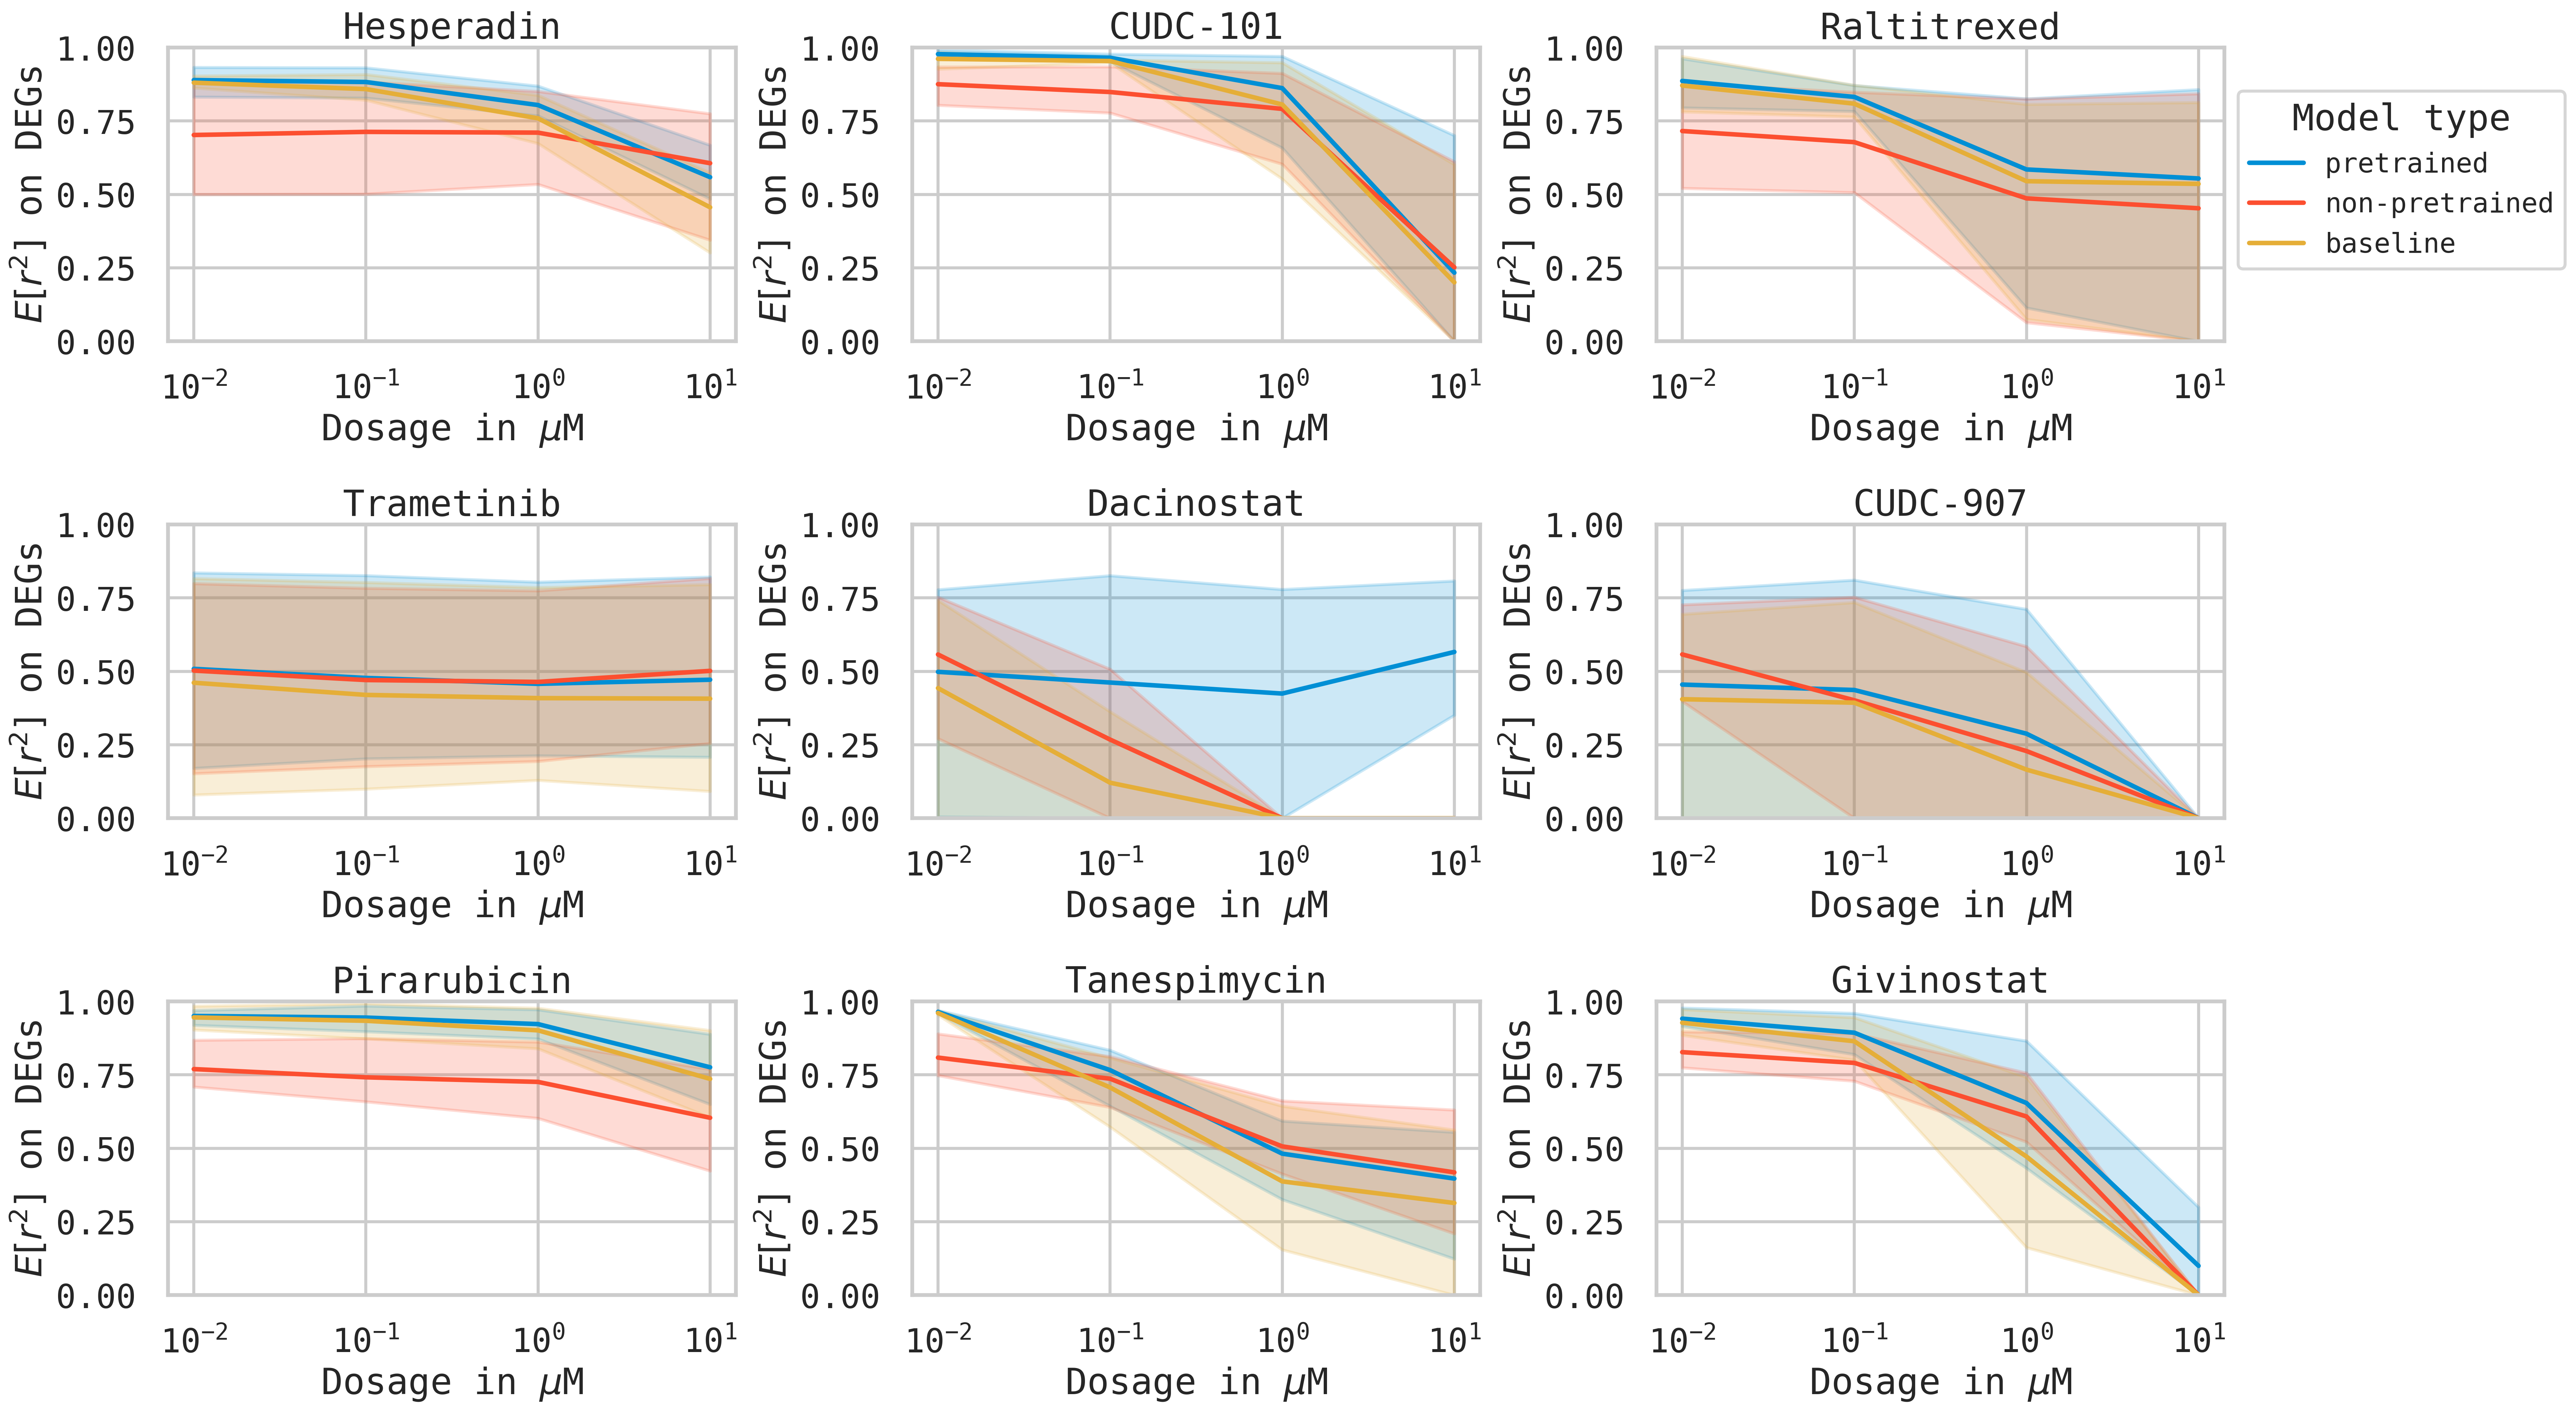

In [22]:
df = df_degs.copy()
df.dose = df.dose*10

rows, cols = 3,3
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 4.5*rows))


for i, drug in enumerate(ood_drugs):
    axis = ax[i//cols, i%cols]
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=axis, palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    axis.set_title(drug)
#     ax[i].set()
    axis.set_ylim([0,1])
    axis.legend().remove()
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.set_xscale("log")

ax[0,2].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left", bbox_to_anchor=(1, 0.2))

plt.tight_layout()
if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'all_drug_examples_grover_extended_degs_black.png', format='png')
    else:
        plt.savefig(FIGURE_DIR/'all_drug_examples_grover_extended_degs.png', format='png')



## Figure 5 for GROVER

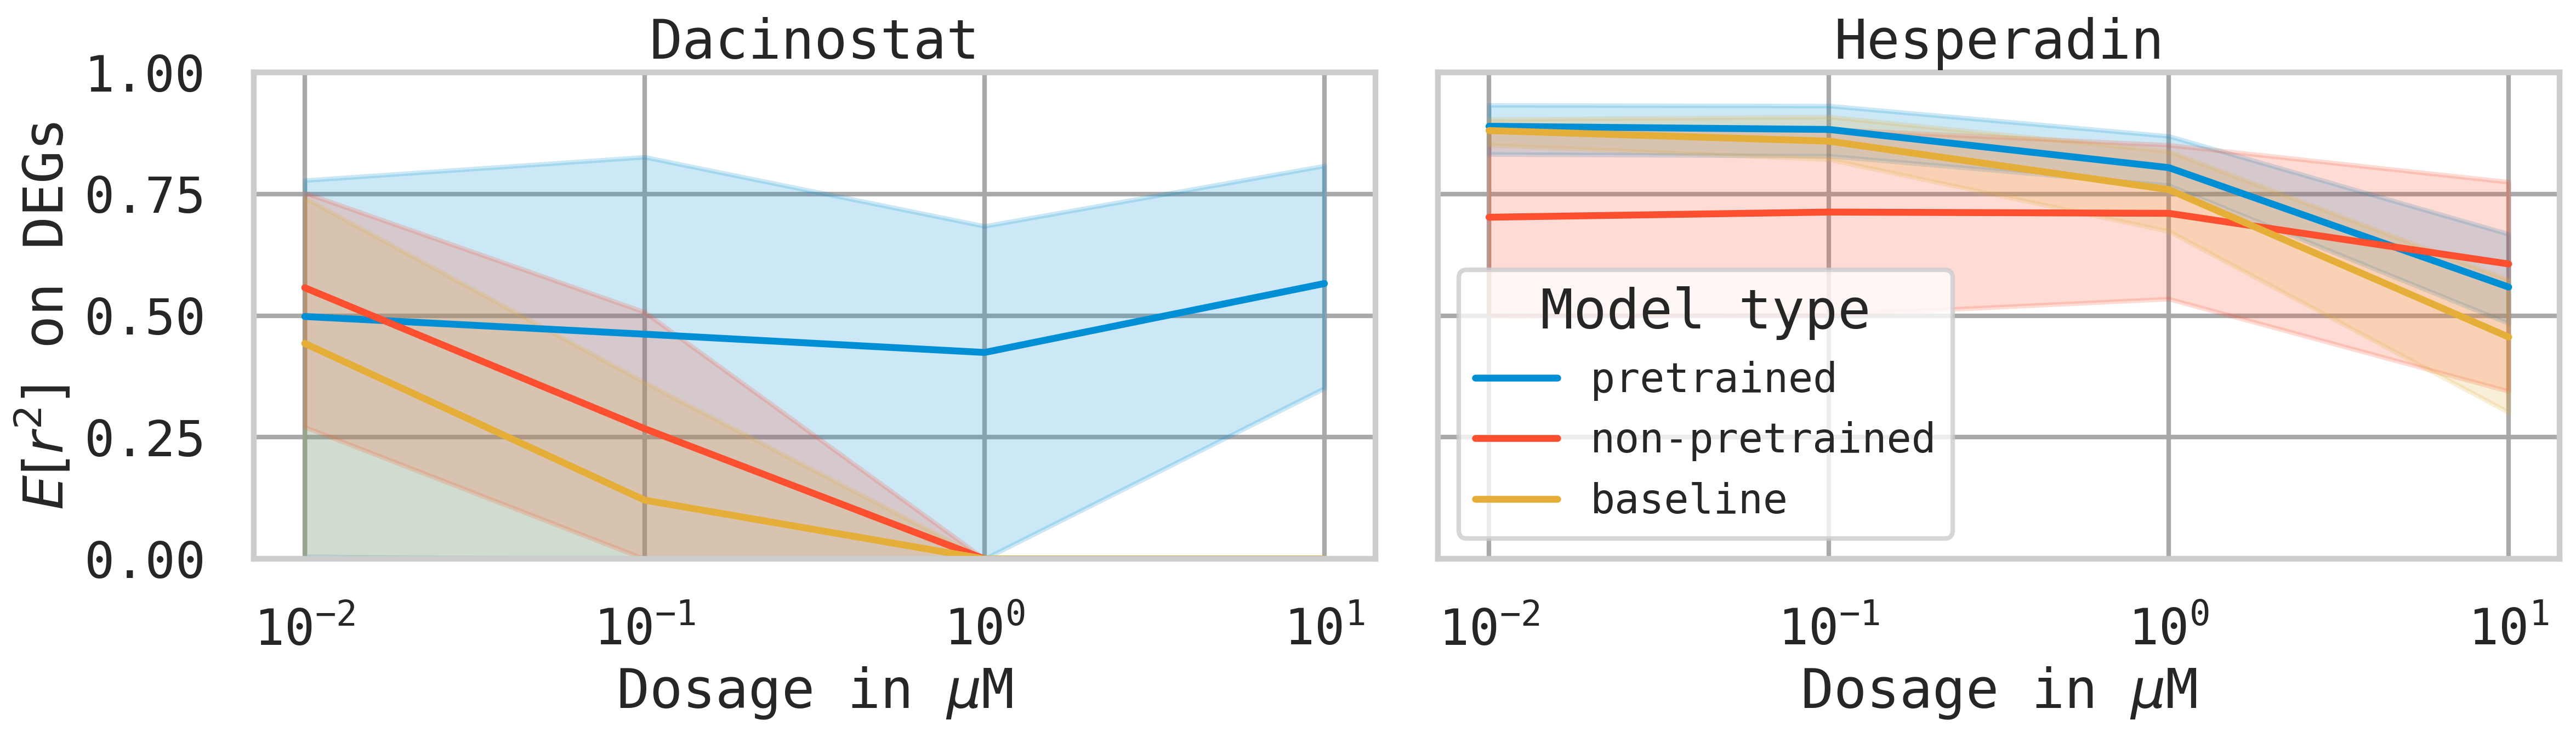

In [23]:
df = df_degs.copy()
df.dose = df.dose*10

STACKED = False

if STACKED:
    # Portrait
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
else:
    # Landscape
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

for i, drug in enumerate(["Dacinostat", "Hesperadin"]):
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=ax[i], palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    ax[i].set_title(drug)
#     ax[i].set()
    ax[i].set_ylim([0,1])
    ax[i].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left") #, bbox_to_anchor=(1, 1)
    ax[i].grid('.', color='darkgrey')

ax[0].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_xlabel("Dosage in $\mu$M") 
ax[0].set_xlabel("Dosage in $\mu$M") 
ax[0].legend().remove()
ax[0].set_xscale("log")
ax[1].set_xscale("log")
plt.tight_layout()


if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'drug_examples_grover_extended_degs_black.png', format='png') # BLACK
    else:
        plt.savefig(FIGURE_DIR/'drug_examples_grover_extended_degs.png', format='png')


____